Importing Necessary Library

In [1]:
# Importing Necessary Libraries
import wandb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Loading the Dataset

In [2]:
config = {
    'path_dir': "/kaggle/input/monkeypox-detection-dataset/converted_data",
}
config

{'path_dir': '/kaggle/input/monkeypox-detection-dataset/converted_data'}

In [3]:
# Initialize Weights & Biases
wandb.login(key="e8a360829806e69a22f56a7eb4c7b07aab8c6485")
wandb.init(project="final-project-ablations", name="amuhairw_monkeypox-detection_run1")

print("[INFO] loading images...")
imagePaths = list(paths.list_images(config['path_dir']))
data = []
labels = []

print(f"Number of image paths loaded: {len(imagePaths)}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amuhairw (delta-group-50). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[INFO] loading images...
Number of image paths loaded: 90


In [4]:
# Define paths directly
root_dir = config["path_dir"]
monkeypox_label = "Monkeypox_gray"
monkeypox_path = f"{root_dir}/{monkeypox_label}"
# chickenpox_path = f"config["path_dir"]/chicken_pox"
chickenpox_label = "Chickenpox_grayscale" #"chicken_pox"
chickenpox_path = f"{root_dir}/{chickenpox_label}"

# Function to load images from a directory with a specific label
def load_images_from_folder(folder, label):
    images = []
    labels_list = []
    count = 0

    # Check if directory exists
    if not os.path.exists(folder):
        print(f"Warning: {folder} directory does not exist")
        return images, labels_list

    # Load all images from the directory
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))  # Resize to match VGG16 input
                images.append(image)
                labels_list.append(label)
                count += 1

    print(f"Loaded {count} images from {folder}")
    return images, labels_list

# Load Chickenpox images
chickenpox_images, chickenpox_labels = load_images_from_folder(chickenpox_path, chickenpox_label)

# Load Monkeypox images
monkeypox_images, monkeypox_labels = load_images_from_folder(monkeypox_path, monkeypox_label)

# Combine the data
data = chickenpox_images + monkeypox_images
labels = chickenpox_labels + monkeypox_labels

# Convert to numpy arrays
data = np.array(data, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels)

print(f"Final dataset size: {len(data)} images")
print(f"Unique labels: {np.unique(labels)}")
print(f"Label counts: {[(label, (labels == label).sum()) for label in np.unique(labels)]}")

Loaded 47 images from /kaggle/input/monkeypox-detection-dataset/converted_data/Chickenpox_grayscale
Loaded 43 images from /kaggle/input/monkeypox-detection-dataset/converted_data/Monkeypox_gray
Final dataset size: 90 images
Unique labels: ['Chickenpox_grayscale' 'Monkeypox_gray']
Label counts: [('Chickenpox_grayscale', 47), ('Monkeypox_gray', 43)]


Image preprocessing and extract the Label

In [5]:
# Create dictionaries to store data by class
class_data = {monkeypox_label: [], chickenpox_label: []}
for img, lbl in zip(data, labels):
    class_data[lbl].append(img)

# Create train and test sets with specific counts
trainX = []
testX = []
trainY = []
testY = []

# Monkeypox: 34 train, 9 test
monkey_images = class_data[monkeypox_label]
if len(monkey_images) >= 43:
    monkey_train = monkey_images[:34]
    monkey_test = monkey_images[34:43]
    trainX.extend(monkey_train)
    testX.extend(monkey_test)
    trainY.extend([monkeypox_label] * len(monkey_train))
    testY.extend([monkeypox_label] * len(monkey_test))
else:
    print(f"Warning: Not enough Monkeypox images. Found {len(monkey_images)}, need 43")

# Chickenpox: 38 train, 9 test
chicken_images = class_data[chickenpox_label]
if len(chicken_images) >= 47:
    chicken_train = chicken_images[:38]
    chicken_test = chicken_images[38:47]
    trainX.extend(chicken_train)
    testX.extend(chicken_test)
    trainY.extend([chickenpox_label] * len(chicken_train))
    testY.extend([chickenpox_label] * len(chicken_test))
else:
    print(f"Warning: Not enough Chickenpox images. Found {len(chicken_images)}, need 47")

# Convert to numpy arrays
trainX = np.array(trainX, dtype="float32")
testX = np.array(testX, dtype="float32")
trainY = np.array(trainY)
testY = np.array(testY)

print(f"Train data shape: {trainX.shape}, Train labels shape: {trainY.shape}")
print(f"Test data shape: {testX.shape}, Test labels shape: {testY.shape}")

Train data shape: (72, 224, 224, 3), Train labels shape: (72,)
Test data shape: (18, 224, 224, 3), Test labels shape: (18,)


In [6]:
# Convert labels to categorical (if needed)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# # Initialize the training data augmentation object
# trainAug = ImageDataGenerator(
#     rotation_range=45, 
#     width_shift_range=0.02, 
#     height_shift_range=0.02, 
#     zoom_range=0.02, 
#     horizontal_flip=True, 
#     fill_mode="nearest"
# )

In [7]:
baseModel =VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# baseModel =ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

In [8]:
# model.summary()

In [9]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 30

In [10]:
import tensorflow as tf
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# #opt = tf.keras.optimizers.SGD(learning_rate=INIT_LR)
# opt = tf.keras.optimizers.RMSprop(learning_rate=INIT_LR)



# opt = Adam(learning_rate=INIT_LR) 

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
# # compile our model
# print("[INFO] compiling model...")
# #opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# model.compile(loss="binary_crossentropy", optimizer=opt,
# 	metrics=["accuracy"])
# #model.compile(loss="hinge", optimizer=opt,
# 	#metrics=["accuracy"])
# # train the head of the network
# print("[INFO] training head...")
# wandb_callback = wandb.keras.WandbMetricsLogger(log_freq="epoch")
# import time
# t1=time.process_time()
# H = model.fit(
# 	trainAug.flow(trainX, trainY, batch_size=BS),
# 	steps_per_epoch=len(trainX) // BS,
# 	validation_data=(testX, testY),
# 	validation_steps=len(testX) // BS,
# 	epochs=EPOCHS,
#      callbacks=[wandb_callback]
# )
# t2 =time.process_time()
# print("process time:", t2-t1)  
# #model.save("vgg16.h5")









# Compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# # Start timing
# t1 = time.process_time()

# Train the model
print("[INFO] training head...")
wandb_callback = wandb.keras.WandbMetricsLogger(log_freq="epoch")
import time
t1=time.process_time()
H = model.fit(
    x=trainX, 
    y=trainY, 
    batch_size=BS,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
     callbacks=[wandb_callback]
)

# End timing
t2 = time.process_time()
print("Process time:", t2 - t1)

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 14s/step - accuracy: 0.5222 - loss: 0.8342 - val_accuracy: 0.5000 - val_loss: 0.7498
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.6667 - loss: 0.7194 - val_accuracy: 0.5000 - val_loss: 0.7346
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.4667 - loss: 0.7756 - val_accuracy: 0.4444 - val_loss: 0.7166
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5000 - loss: 0.7637 - val_accuracy: 0.3889 - val_loss: 0.7130
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.5333 - loss: 0.7050 - val_accuracy: 0.4444 - val_loss: 0.7081
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7500 - loss: 0.6825 - val_accuracy: 0.4444 - val_loss: 0.7053
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.5444 - loss: 0.7113 - val_accuracy: 0.4444 - val_loss: 0.7007
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5000 - loss: 0.7165 - val_accuracy: 0.5000 - val_loss: 0.6984
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.4667 - loss: 0.7088 - val_accuracy: 0.6111 - val_loss: 0.6941
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6667 - loss: 0.6966 - val_accuracy: 0.6111 - val_loss: 0.

In [12]:
print(len(H.history['loss']))

100


In [13]:
model.save_weights("my_model_weights.weights.h5")

In [14]:
# Log model weights to W&B as an artifact
artifact = wandb.Artifact("monkeypox-model", type="model")
artifact.add_file("my_model_weights.weights.h5")
wandb.log_artifact(artifact)

#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step 
                      precision    recall  f1-score   support

Chickenpox_grayscale       0.79      0.89      0.84        38
      Monkeypox_gray       0.86      0.74      0.79        34

            accuracy                           0.82        72
           macro avg       0.83      0.82      0.82        72
        weighted avg       0.82      0.82      0.82        72



In [15]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log metrics to W&B
wandb.log({
    "train_accuracy": acc,
    "train_sensitivity": sensitivity,
    "train_specificity": specificity
})

[[34  4]
 [ 9 25]]
acc: 0.8194
sensitivity: 0.8947
specificity: 0.7353


In [16]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
testpredict = np.argmax(predIdys, axis=1)
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
                      precision    recall  f1-score   support

Chickenpox_grayscale       0.73      0.89      0.80         9
      Monkeypox_gray       0.86      0.67      0.75         9

            accuracy                           0.78        18
           macro avg       0.79      0.78      0.77        18
        weighted avg       0.79      0.78      0.77        18



In [17]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log test metrics to W&B
wandb.log({
    "test_accuracy": acc,
    "test_sensitivity": sensitivity,
    "test_specificity": specificity
})

[[8 1]
 [3 6]]
acc: 0.7778
sensitivity: 0.8889
specificity: 0.6667


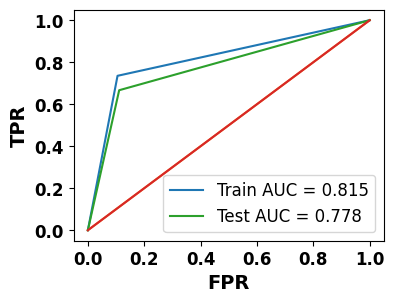

<Figure size 640x480 with 0 Axes>

In [18]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
fig = plt.figure(figsize = (4, 3))
fpr1,tpr1,_=roc_curve(np.argmax(trainY, axis=1),np.argmax(predIdxs, axis=1))
fpr2,tpr2,_=roc_curve(np.argmax(testY, axis=1),np.argmax(predIdys, axis=1))
area_under_curve1=auc(fpr1,tpr1)
random_probs=[0 for i in range(len(trainY.ravel()))]
p_fpr1,p_tpr1,threshold=roc_curve(trainY.ravel(),random_probs, pos_label=1)
plt.plot(fpr1,tpr1, label='Train AUC = {:.3f}'.format(area_under_curve1))
plt.plot(p_fpr1, p_tpr1)
area_under_curve2=auc(fpr2,tpr2)
random_probs2=[0 for i in range(len(testY.ravel()))]
p_fpr2,p_tpr2,threshold=roc_curve(testY.ravel(),random_probs2, pos_label=1)
plt.plot(fpr2,tpr2, label='Test AUC = {:.3f}'.format(area_under_curve2))
plt.plot(p_fpr2, p_tpr2)

    # x label
plt.xlabel('FPR',fontsize=14, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('TPR', fontsize=14, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
plt.legend()
plt.legend(prop={'size':12})
plt.savefig('ROC',dpi=200, bbox_inches='tight')
plt.show();

# Log ROC curve to W&B
wandb.log({"ROC_curve": wandb.Image(plt)})

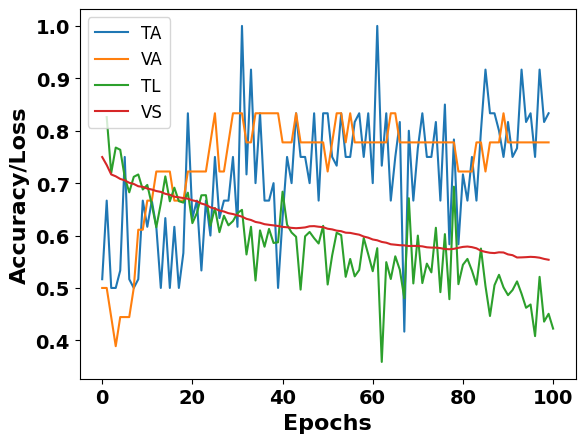

epoch/accuracy,▂▇▂▄▂█▅▇▆▅▂▇▆▇▅█▇▆█▇█▇█▆▆█▁▅▇▇▄▆▇▅█▇▇███
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▆▆▆▅▆▅▅▅▄▅▅▂▄▄▅▄▄▂▃▃▃▃▃▂▄▂▃▂▂▂▄▁▂▂▂▂▁
epoch/val_accuracy,▁▃▃▅▆▅▆▆▇▆███▇███▇█▇▇▇▇▇▇▇▇▇▇▆▆▇▇▇▇█▇▇▇▇
epoch/val_loss,█▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_sensitivity,▁
test_specificity,▁
train_accuracy,▁
train_sensitivity,▁


<Figure size 640x480 with 0 Axes>

In [19]:

from matplotlib.ticker import FormatStrFormatter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VS')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'size':12})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('ACC',dpi=200, bbox_inches='tight')
plt.show()

# Log accuracy/loss plot to W&B
wandb.log({"Accuracy_Loss_Plot": wandb.Image(plt)})

# Finish W&B run
wandb.finish()